In [1]:
#!pip install wordcloud

In [2]:
#base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')
import seaborn as sns

#preprocess
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from collections import  Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

#wordcloud
from wordcloud import WordCloud, STOPWORDS

#stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))

#embedding
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#modeling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Input

# col 생략 없이 출력
pd.set_option('display.max_columns', None)
# col 최대 너비 200
pd.set_option('max_colwidth', 200)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hkny0\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hkny0\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hkny0\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hkny0\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hkny0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train = pd.read_csv('train.csv',index_col=0)
test = pd.read_csv('test_x.csv',index_col=0)

In [4]:
train.head()

,text,author
index,,
0,"He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; lo...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in spirits, when, instead of being again surprised by M...",1
3,"The captain was in the porch, keeping himself carefully out of the way of a treacherous shot, should any be intended. He turned and spoke to us, “Doctor's watch on the lookout. Dr. odin take the n...",4
4,"“Have mercy, gentlemen!” odin flung up his hands. “Don’t write that, anyway; have some shame. Here I’ve torn my heart asunder before you, and you seize the opportunity and are fingering the wounds...",3


In [5]:
train.shape, test.shape

((54879, 2), (19617, 1))

In [6]:
# additional data cleaning
# 이 함수를 test에도 적용하면 됨

def clean_text(texts): 
    corpus = [] 
    for i in range(0, len(texts)): 

        review = re.sub("[^a-zA-Z -]","",texts[i]) #대괄호 내 문자들을 제외한 모든 문자 제거
        review = review.lower() #소문자 변환
        review = re.sub(r'\s+', ' ', review) #extra space 제거
        review = re.sub(r'\s+', ' ', review) #spaces 제거
        review = re.sub(r"^\s+", '', review) #space from start 제거
        review = re.sub(r'\s+$', '', review) #space from the end 제거
        review = re.sub(r'_', ' ', review) #space from the end 제거
        review = re.sub(r'"+', ' ', review) #spaces 제거   
        review = re.sub('-{2,}', ' ', review) #-이 2번이상 반복되면 제거   

        corpus.append(review) 
  
    return corpus

In [7]:
temp = clean_text(train['text'])
train['clean_text'] = temp

temp = clean_text(test['text'])
test['clean_text'] = temp

test.head() #깨끗함

,text,clean_text
index,,
0,"“Not at all. I think she is one of the most charming young ladies I ever met, and might have been most useful in such work as we have been doing. She had a decided genius that way: witness the way...",not at all i think she is one of the most charming young ladies i ever met and might have been most useful in such work as we have been doing she had a decided genius that way witness the way in w...
1,"""No,"" replied he, with sudden consciousness, ""not to find it in YOU; for I cannot be ignorant that to you, to your goodness, I owe it all.--I feel it--I would express it if I could--but, as you we...",no replied he with sudden consciousness not to find it in you for i cannot be ignorant that to you to your goodness i owe it all i feel it i would express it if i could but as you well know i am n...
2,"As the lady had stated her intention of screaming, of course she would have screamed at this additional boldness, but that the exertion was rendered unnecessary by a hasty knocking at the door: wh...",as the lady had stated her intention of screaming of course she would have screamed at this additional boldness but that the exertion was rendered unnecessary by a hasty knocking at the door which...
3,“And then suddenly in the silence I heard a sound which sent my heart into my mouth. It was the clank of the levers and the swish of the leaking cylinder. He had set the engine at work. The lamp s...,and then suddenly in the silence i heard a sound which sent my heart into my mouth it was the clank of the levers and the swish of the leaking cylinder he had set the engine at work the lamp still...
4,"His conviction remained unchanged. So far as I know--and I believe his honest heart was transparent to me--he never wavered again, in his solemn certainty of finding her. His patience never tired....",his conviction remained unchanged so far as i know and i believe his honest heart was transparent to me he never wavered again in his solemn certainty of finding her his patience never tired and a...


In [8]:
# 추가
stop = stopwords.words('english')
stop.append('odin')
stop.append('say')
stop.append('dont')
stop = set(stop)

### 1. 빈도기반 DTM 행렬로 MLP

In [10]:
### 1. 빈도기반 DTM 행렬로 MLP
# train데이터와 validation데이터 나누기
from sklearn.model_selection import train_test_split
train_x = train['clean_text']
train_y = train['author']

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, shuffle=True, random_state=10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(train_x.shape, train_y.shape)

(38415,) (16464,) (38415,) (16464,)
(54879,) (54879,)


In [11]:
vocab_size = 1000
def prepare_data(train_data, test_data, mode): # 전처리 함수
    tokenizer = Tokenizer(num_words = vocab_size) # vocab_size 개수만큼의 단어만 사용한다.
    tokenizer.fit_on_texts(train_data)
    X_train = tokenizer.texts_to_matrix(train_data, mode=mode) # 샘플 수 × vocab_size 크기의 행렬 생성
    X_test = tokenizer.texts_to_matrix(test_data, mode=mode) # 샘플 수 × vocab_size 크기의 행렬 생성
    return X_train, X_test, tokenizer.index_word

In [12]:
# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def fit_and_evaluate(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(256, input_shape=(vocab_size,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.1)
    score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
    return score[1]

In [13]:
print('훈련 샘플 본문의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 본문의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 본문의 크기 : (38415,)
훈련 샘플 레이블의 크기 : (38415,)
테스트 샘플 본문의 크기 : (16464,)
테스트 샘플 레이블의 크기 : (16464,)


In [14]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))
print('빈도수 상위 9999번 단어 : {}'.format(index_to_word[9999]))

NameError: name 'index_to_word' is not defined

In [15]:
### 2. 임베딩 레이어 없이 1D 신경망 (08-04)
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional

### 3. XGBoost
참고1 : https://velog.io/@highway92/XGBoost-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0%EB%93%A4   
참고2 : https://www.kaggle.com/code/emmanuelfwerr/xgboost-multi-class-classification

In [16]:
### 3. XGBoost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [17]:
# train데이터와 validation데이터 나누기
train_x = train['clean_text']
train_y = train['author']
test_x = test['clean_text']

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, shuffle=True, random_state=10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(train_x.shape, train_y.shape)
print(test_x.shape)

(38415,) (16464,) (38415,) (16464,)
(54879,) (54879,)
(19617,)


In [18]:
vocab_size = 1000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train, mode='tfidf')
X_test = tokenizer.texts_to_matrix(X_test, mode='tfidf')
print(X_train.shape, X_test.shape)

(38415, 1000) (16464, 1000)


**predict_proba사용 시 평가 지표 관련 자료**   
http://okminseok.blogspot.com/2017/09/ml-xgboost.html   
https://nicola-ml.tistory.com/102   
https://gongboogi.tistory.com/4   
https://velog.io/@sset2323/03-05.-ROC-%EA%B3%A1%EC%84%A0%EA%B3%BC-AUC   
https://www.inflearn.com/questions/55185/predict-proba-x-test

In [43]:
# balancing 'target' class weights
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

# declaring and fitting xgb classifier
xgb_clf = XGBClassifier(n_estimators=500, learning_rate = 0.1, max_depth = 8,
                     objective='multi:softprob', num_class = 5, reg_lambda=1,
                     eval_metric=['auc','mlogloss'], seed=42)
xgb_clf.fit(X_train, y_train, verbose=0, sample_weight = sample_weights,
            early_stopping_rounds=100, eval_set=[(X_train, y_train),(X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

In [48]:
import xgboost as xgb

# 모델 정의 및 학습
#xgb_model = xgb.XGBRegressor(**param).fit(trainData.features, trainData.labels)

# 파일명
filename = '500_8_0.65.model'

# 모델 저장
xgb_clf.save_model(filename)

# 모델 불러오기
#new_xgb_clf = xgb.XGBClassifier() # 모델 초기화
#new_xgb_clf.load_model(filename) # 모델 불러오기

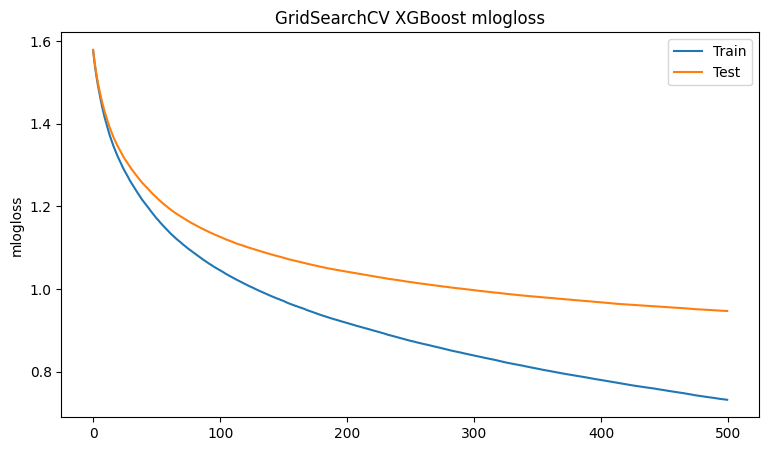

In [20]:
# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

In [39]:
results['validation_0']['mlogloss']

[1.570284,
 1.537064,
 1.508239,
 1.482502,
 1.459743,
 1.439211,
 1.42039,
 1.403101,
 1.386444,
 1.370294,
 1.356117,
 1.342174,
 1.328639,
 1.316735,
 1.305094,
 1.292975,
 1.283146,
 1.273583,
 1.26447,
 1.254859,
 1.246907,
 1.238373,
 1.229916,
 1.222504,
 1.215752,
 1.208685,
 1.201036,
 1.194348,
 1.188529,
 1.182153,
 1.176345,
 1.171088,
 1.164651,
 1.15819,
 1.152282,
 1.146897,
 1.141521,
 1.136719,
 1.131899,
 1.126976,
 1.120368,
 1.115826,
 1.11148,
 1.107096,
 1.102411,
 1.097891,
 1.094112,
 1.088865,
 1.084285,
 1.079666,
 1.075796,
 1.071575,
 1.067652,
 1.063535,
 1.0595,
 1.056333,
 1.053062,
 1.048572,
 1.044975,
 1.041869,
 1.038529,
 1.035535,
 1.031495,
 1.028619,
 1.025206,
 1.022475,
 1.019538,
 1.016369,
 1.014012,
 1.010673,
 1.007677,
 1.005111,
 1.002448,
 0.999814,
 0.997239,
 0.994402,
 0.991702,
 0.988514,
 0.986238,
 0.983456,
 0.981069,
 0.978483,
 0.976091,
 0.973368,
 0.970905,
 0.968806,
 0.966745,
 0.964792,
 0.96235,
 0.959712,
 0.957324,
 0.955

In [45]:
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)

y_pred_proba

array([[0.14949918, 0.10484778, 0.20285791, 0.44414136, 0.09865372],
       [0.4756417 , 0.31119913, 0.14012523, 0.00740366, 0.06563027],
       [0.54179686, 0.03249757, 0.14781915, 0.19377998, 0.08410649],
       ...,
       [0.9324872 , 0.0173871 , 0.01765259, 0.01487596, 0.01759719],
       [0.1667389 , 0.07435174, 0.3785892 , 0.01606223, 0.3642579 ],
       [0.11874971, 0.05621466, 0.35670844, 0.19355588, 0.2747713 ]],
      dtype=float32)

In [42]:
#xgb_roc_score = roc_auc_score(y_test, y_pred_proba)
#print('ROC AUC 값: {0:.4f}'.format(xgb_roc_score))

#xgb_roc_score = roc_auc_score(y_test, y_pred_proba, average='macro', multi_class='ovr')
#print(xgb_roc_score)

AxisError: axis 1 is out of bounds for array of dimension 1

In [36]:
#y_pred = xgb_clf.predict_proba(X_test)
y_score = np.transpose([y_pred[:,1] for y_pred in xgb_clf.predict_proba(X_test)])

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

# print accuracy
#print("Accuracy: ", accuracy_score(y_test, y_pred))

# print precision, recall, F1-score per each class/tag
#print(classification_report(y_test, y_pred))

# print confusion matrix, check documentation for sorting rows/columns
#print(confusion_matrix(y_test, y_pred))

roc_auc_score(y_test, y_score, average=None, multi_class='ovr')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [47]:
## ---------- Model Classification Report ----------
## get predictions and create model quality report
#from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
#from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score

y_pred = xgb_clf.predict(X_test)

#print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.60      0.64      4010
           1       0.65      0.64      0.64      2110
           2       0.57      0.62      0.60      3487
           3       0.73      0.72      0.73      4544
           4       0.55      0.61      0.58      2313

    accuracy                           0.65     16464
   macro avg       0.64      0.64      0.64     16464
weighted avg       0.65      0.65      0.65     16464



> 정확도 보는 방법???ㅠㅠㅠ   
softmax/softprob과 predict/predict_proba의 차이...?   
predict_proba는 roc_auc_score보라는데 인덱스설정을 어떻게 해야할지...?(argmax...?)

#### 실제 test에 적용

In [ ]:
# 실제 test에 적용
train_x = tokenizer.texts_to_matrix(train_x, mode='tfidf')
test_x = tokenizer.texts_to_matrix(test_x, mode='tfidf')
print(train_x.shape, test_x.shape, train_y.shape)

In [ ]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=train_y)

# declaring and fitting xgb classifier
xgb_clf = XGBClassifier(n_estimators=500,learning_rate = 0.1, max_depth = 8,
                     objective='multi:softprob', num_class = 5, reg_lambda=1,
                     eval_metric=['merror','mlogloss'], seed=42)
xgb_clf.fit(train_x, train_y, verbose=0, sample_weight = sample_weights)

In [ ]:
pred_y = xgb_clf.predict_proba(test_x)
pred_y

In [ ]:
pred_y.shape

In [ ]:
test_x.shape

In [ ]:
sub = pd.read_csv('sample_submission.csv')
sub['0'] = [x[0] for x in pred_y]
sub['1'] = [x[1] for x in pred_y]
sub['2'] = [x[2] for x in pred_y]
sub['3'] = [x[3] for x in pred_y]
sub['4'] = [x[4] for x in pred_y]

In [ ]:
display(sub[:10])
#sub.to_csv('sub3.csv', index = False)

### 파생변수

In [ ]:
# train데이터와 validation데이터 나누기
train2 = train.copy()
train_x = train['clean_text']
train_y = train['author']
test_x = test['clean_text']

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, shuffle=True, random_state=10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(train_x.shape, train_y.shape)
print(test_x.shape)

vocab_size = 1000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train, mode='tfidf')
X_test = tokenizer.texts_to_matrix(X_test, mode='tfidf')
print(X_train.shape, X_test.shape)

In [ ]:
train